# Contour Monte Carlo
This Julia notebook demonstrates how to perform Contour Monte Carlo to invert the Michaelis-Menten equation. Note that the code uses the `RCall` Julia package to call R, in order to use the vine copula kernel density estimation available in the R package `kdevine`.

In [110]:
using RCall, Compat, Random, Distributions, Plots, DifferentialEquations

R"library(kdevine)"

function f_solve(f_deriv, initial, tspan, parameters)
    prob = ODEProblem(f_deriv, initial, tspan, parameters)
    sol = solve(prob)
    return sol
end

function f_sample_solve_uniform(num_samples, population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial)
    n_params = size(bounds)[1]
    samples = zeros((num_samples, n_params))
    for i = 1:n_params
        samples[:, i] = rand(Uniform(bounds[i, 1], bounds[i, 2]), num_samples)
    end
    mOutputs = zeros((num_samples, length(population_sample)))
    for i in 1:num_samples
        sol = f_solve(f_deriv, initial, tspan, samples[i, :]);
        for j = 1:length(population_sample)
           mOutputs[i, j] = sol(times_solve[j], idxs=population_sample[j])
        end
    end
    return mOutputs
end

function f_estimate_kdevine(mOutputs)
    @rput mOutputs
    R"fit <- kdevine(mOutputs)"
end

function dkdevine(params)
    @rput params
    R"z <- dkdevine(params, fit)"
    @rget z
    return z
end

function f_step_bounds(vCurrent, bounds, sigma)
    vProposed = zeros(size(bounds)[1])
    for i = 1:length(vProposed)
        temp = (rand(Normal(vCurrent[i] - bounds[i, 1], sigma[i]), 1)[1] % (bounds[i, 2] - bounds[i, 1]))
        if temp < 0
            temp += bounds[i, 2]
        else
            temp += bounds[i, 1]
        end
        vProposed[i] = temp
    end
    return vProposed
end

function f_mcmc_uniform(num_samples, dist_target, f_dkdevine, sigma, population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial)
    mInputs = zeros((num_samples, size(bounds)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    # initial points
    mInputs[1, :] = f_step_bounds(mean(bounds, dims=2), bounds, sigma)
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, initial, tspan, mInputs[1, :]);
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = logpdf(dist_target, mOutputs[1, :])
    log_contour_current = log(f_dkdevine(mOutputs[1, :]))
    # MCMC
    for i = 2:num_samples
        vProposed = f_step_bounds(mInputs[i - 1, :], bounds, sigma)
        sol = f_solve(f_deriv, initial, tspan, vProposed);
        for j = 1:length(population_sample)
            vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
        end
        log_pdf_proposed = logpdf(dist_target, vOutputs_temp)
        log_contour_proposed = log(f_dkdevine(vOutputs_temp))
        log_r = ((log_pdf_proposed + log_contour_current) -
                 (log_pdf_current + log_contour_proposed))
        if log_r > log(rand(Uniform(), 1)[1])
            mInputs[i, :] = vProposed
            mOutputs[i, :] = vOutputs_temp
            log_pdf_current = log_pdf_proposed
            log_contour_current = log_contour_proposed
        else
            mInputs[i, :] = mInputs[i - 1, :]
            mOutputs[i, :] = mOutputs[i - 1, :]
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs)
end

f_mcmc_uniform (generic function with 1 method)

## Michaelis-Menten kinetics

First estimate volume of contours.

In [ ]:
function deriv_michaelis_menten(dydt, y, p, t)
    k_f = p[1]
    k_r = p[2]
    k_cat = p[3]
    dydt[1] = -k_f * y[1] * y[2] + k_r * y[3] + k_cat * y[3]
    dydt[2] = -k_f * y[1] * y[2] + k_r * y[3]
    dydt[3] = k_f * y[1] * y[2] - k_r * y[3] - k_cat * y[3]
    dydt[4] = k_cat * y[3]
end

mBounds = [[0.2 15]; [0.2 2]; [0.5 3]];

tspan = (0.0, 10.0)
initial = [4.0; 8.0; 0.0; 0.0];

mOutputs = @time f_sample_solve_uniform(10000, [1, 2], [2, 1], tspan, f_solve, deriv_michaelis_menten, mBounds, initial);

@time f_estimate_kdevine(mOutputs);

Now do MCMC.

In [6]:
d = MvNormal([2.8, 1.0], [[0.02 -0.01]; [-0.01 0.02]]);
temp = @time f_mcmc_uniform(5000, d, dkdevine, [1, 0.1, 0.1], [1, 2], [2, 1], tspan, f_solve, deriv_michaelis_menten, mBounds, initial);

 65.132850 seconds (6.89 M allocations: 573.806 MiB, 0.27% gc time)


Plot the input distribution.

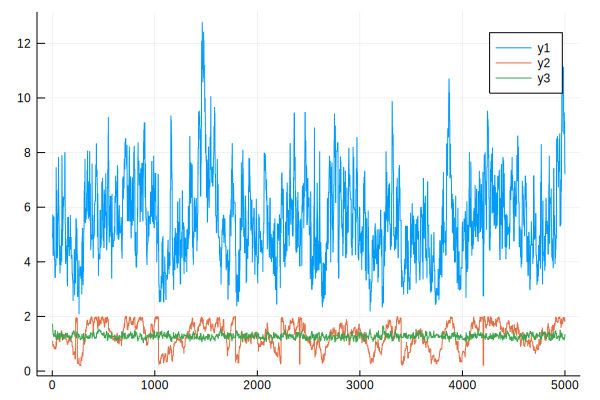

In [7]:
plot(temp["inputs"])

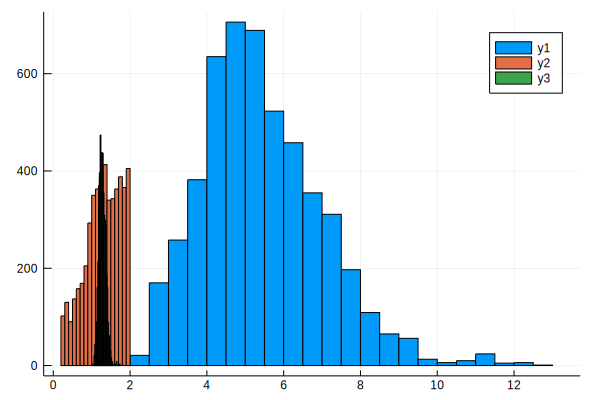

In [15]:
histogram(temp["inputs"])

Plot the output distributions.

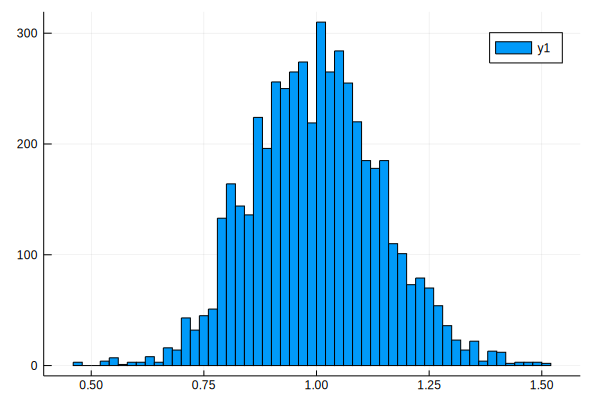

In [9]:
histogram(temp["outputs"][:, 2])

Check how close to $\mathcal{N}([2.8, 1.0], [[0.02, -0.01]; [-0.01, 0.02]])$ target.

In [16]:
println(cov(temp["outputs"]))
println(mean(temp["outputs"], dims=1))

[0.0213836 -0.0103285; -0.0103285 0.0204802]
[2.80375 0.999906]


## Target a bimodal distribution

Find distributions which are different to current.

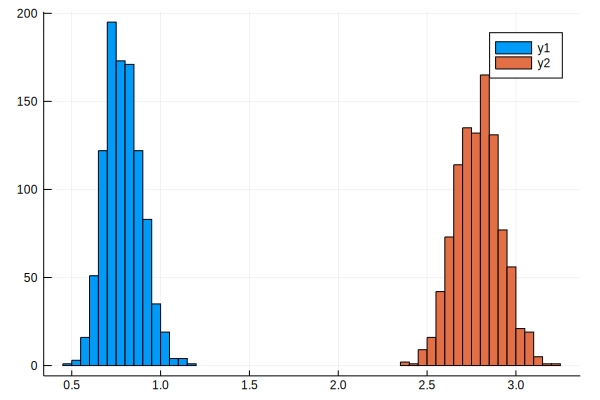

In [49]:
n = 1000
mOutputs = zeros((n, 2))
samples = rand(MvNormal([2.5, 0.5, 0.5], 0.05), n)
for i = 1:n
    sol = f_solve(deriv_michaelis_menten, [4.0; 8.0; 0.0; 0.0], tspan, samples[:, i]);
    mOutputs[i, :] = [sol(2, idxs=1), sol(1, idxs=2)]
end
histogram(mOutputs)

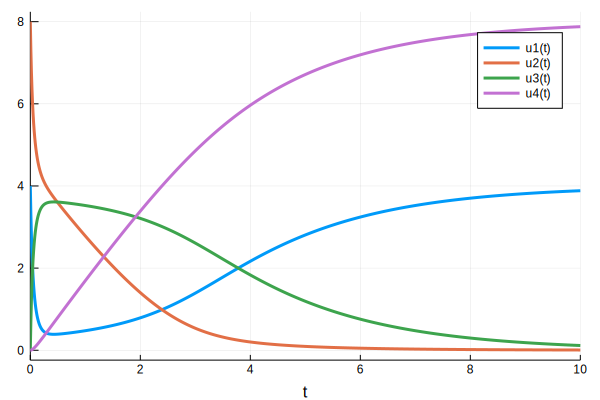

In [51]:
sol = f_solve(deriv_michaelis_menten, [4.0; 8.0; 0.0; 0.0], tspan, [2.5; 0.5; 0.5]);
plot(sol)

In [55]:
mean(mOutputs, dims=1)
cov(mOutputs)

2×2 Array{Float64,2}:
  0.0103909  -0.0118809
 -0.0118809   0.0161864

In [78]:
dist=MixtureModel(MvNormal[MvNormal([0.8, 2.8], [[0.01 -0.01]; [-0.01 0.016]]),
        MvNormal([2.8, 1.0], [[0.02 -0.01]; [-0.01 0.02]])]);

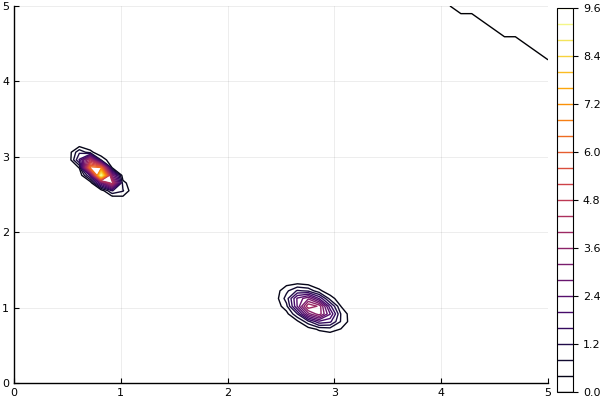

In [79]:
using Plots
pyplot()
V(x,y) = pdf(dist, [x, y])
x = range(0, 5, length=50)
y = range(0, 5, length=50)
contour(x,y, (x,y)->V(x,y), levels=30)

In [80]:
temp = @time f_mcmc_uniform(5000, dist, dkdevine, [1, 0.1, 0.1], [1, 2], [2, 1], tspan, f_solve, deriv_michaelis_menten, mBounds, initial);

 38.148555 seconds (7.05 M allocations: 580.705 MiB, 0.34% gc time)


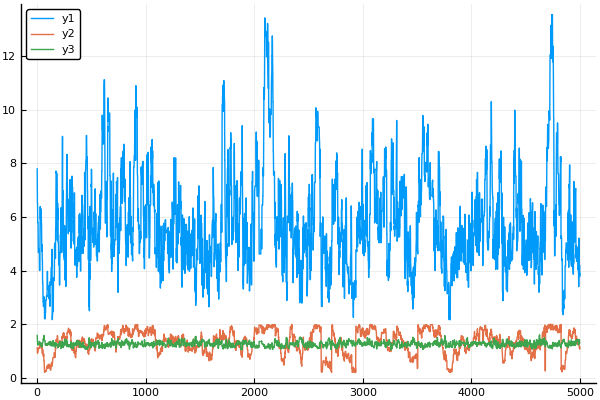

In [81]:
plot(temp["inputs"])

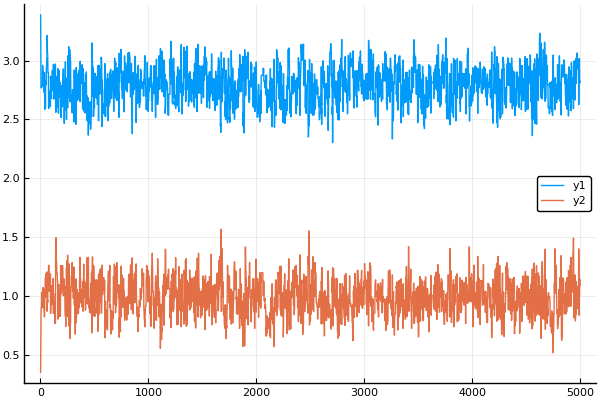

In [82]:
plot(temp["outputs"])

In [91]:
using KernelDensity
f = kde(mOutputs);

In [96]:
plot(map(x->pdf(f, 1, x), range(0, 5, 10)))

MethodError: MethodError: no method matching range(::Int64, ::Int64, ::Int64)
Closest candidates are:
  range(::Number, ::Number; kwargs...) at C:\Users\bclamber\.julia\packages\Compat\lwK4K\src\deprecated.jl:71
  range(::Any, ::Any; length, step) at range.jl:90
  range(::Any; length, stop, step) at range.jl:87

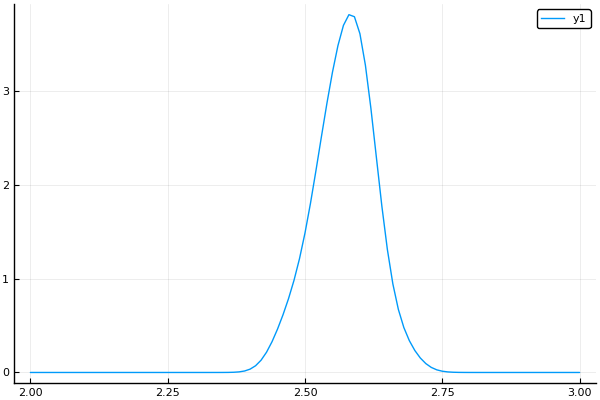

In [109]:
xx=collect(2:0.01:3)
plot(xx, map(x->pdf(f, 1, x), collect(2:0.01:3)))